# Reading from Kaggle

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'arxiv-cs-papers-multi-label-classification-200k-v1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3372297%2F5864998%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240225%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240225T060706Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2e28c8912c28a40d02aef686aea5ed4954336b4a6effae6a150b99781f164b25e3622947563f213bd401e189db50c6df99dd0e78fb62e70d37897c9a7724b53b758815abe58deebcc6475efc1f5ff035bd919945e6a732ff8b6c5ab55b37b694b1ae5f73d34277ed58f889a4f82fdd94ad66faf8ec04a2e81c7b929184d2709c5c42ffaa6f6da57715fffab00be0dce0cc081925a28e9cbd539606dc700668099aef6e71d880b6b9c915bcd40054047a6f8900d98910c38c29905e81fbd1f59380dfd79e9cdd179c1423409bd31da3b7f7e409728e1b18e751104830b372faa6d4880969057be836e8b362047f91b999278ffd6cd841563ed6f364d081e58306'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 83841332 bytes downloaded
Downloaded and uncompressed: arxiv-cs-papers-multi-label-classification-200k-v1
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arxiv-cs-papers-multi-label-classification-200k-v1/cs_papers_api.csv


# Imports

In [3]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 12.1 MB/s eta 0:00:00


In [4]:
%%capture
!pip install transformers==4.28.0 datasets
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb

In [5]:
import transformers
transformers.__version__

'4.28.0'

In [6]:
import os
import torch
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
from typing import Dict
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from datasets import DatasetDict, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import plotly.express as px
from collections import Counter, defaultdict
import ast
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Exploration dataset

In [8]:
df = pd.read_csv("/kaggle/input/arxiv-cs-papers-multi-label-classification-200k-v1/cs_papers_api.csv")
df

,paper_id,title,abstract,year,primary_category,categories
0,2301.02657v1,TarViS: A Unified Approach for Target-based Vi...,The general domain of video segmentation is cu...,2023-01-06 18:59:52+00:00,cs.CV,cs.CV cs.AI cs.LG
1,2301.02642v1,Triple-stream Deep Metric Learning of Great Ap...,We propose the first metric learning system fo...,2023-01-06 18:36:04+00:00,cs.CV,cs.CV cs.AI cs.LG
2,2301.02610v1,Feedback-Gated Rectified Linear Units,Feedback connections play a prominent role in ...,2023-01-06 17:14:11+00:00,cs.NE,cs.NE cs.AI
3,2301.02593v1,Multi-Agent Reinforcement Learning for Fast-Ti...,To integrate high amounts of renewable energy ...,2023-01-06 16:41:51+00:00,cs.MA,cs.MA cs.AI cs.LG cs.SY
4,2301.02561v1,Multi-Vehicle Trajectory Prediction at Interse...,Traditional approaches to prediction of future...,2023-01-06 15:13:23+00:00,cs.RO,cs.RO cs.AI
...,...,...,...,...,...,...
200089,1610.07090v1,STEPS: Predicting place attributes via spatio-...,"In recent years, a vast amount of research has...",2016-10-22 19:41:44+00:00,cs.SI,cs.SI
200090,1610.07772v1,Visual Themes and Sentiment on Social Networks...,Online Social Networks explode with activity w...,2016-10-25 07:56:43+00:00,cs.SI,cs.SI
200091,1610.08098v2,The Effect of Pokémon Go on The Pulse of the C...,"Pok\'emon Go, a location-based game that uses ...",2017-09-18 16:50:12+00:00,cs.SI,cs.SI
200092,1610.08686v1,Polarized User and Topic Tracking in Twitter,Digital traces of conversations in micro-blogg...,2016-10-27 10:03:31+00:00,cs.SI,cs.SI


In [ ]:
df.primary_category.value_counts()

cs.LG    19312
cs.CR     9539
cs.SE     9126
cs.IT     9109
cs.DS     8893
cs.CV     8843
cs.NI     8627
cs.LO     8105
cs.DC     7879
cs.CL     7107
cs.HC     6853
cs.CY     6580
cs.IR     6540
cs.SI     6281
cs.GT     6248
cs.AI     5832
cs.DB     5192
cs.NE     5006
cs.CC     4612
cs.SD     4560
cs.SY     4560
cs.RO     4259
cs.PL     4253
cs.DM     3969
cs.CG     3801
cs.DL     3033
cs.CE     3009
cs.FL     2535
cs.AR     2284
cs.MA     2118
cs.OH     1969
cs.GR     1954
cs.MM     1810
cs.ET     1732
cs.SC     1127
cs.PF      995
cs.NA      971
cs.MS      950
cs.OS      418
cs.GL      103
Name: primary_category, dtype: int64

In [9]:
df['labels'] = df.categories.str.split().tolist()

In [ ]:
all_tags = [tag for tags_list in df['labels'] for tag in tags_list]
d_tags_counter = Counter(all_tags)
tags, frequencies = list(zip(*d_tags_counter.most_common(n=50)))

fig = px.bar(x=tags, y=frequencies)
fig.update_xaxes(title="tags")
fig.update_yaxes(title="frequencies")
fig.show()

In [ ]:
total_duplicate_titles = sum(df["title"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")


There are 704 duplicate titles.


In [10]:
df = df[~df["title"].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 199390 rows in the deduplicated dataset.


In [11]:
df['labels_to_string'] = df['labels'].apply(str)

<ipython-input-11-83be0961d004>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels_to_string'] = df['labels'].apply(str)


In [ ]:
df['labels_to_string']

0                  ['cs.CV', 'cs.AI', 'cs.LG']
1                  ['cs.CV', 'cs.AI', 'cs.LG']
2                           ['cs.NE', 'cs.AI']
3         ['cs.MA', 'cs.AI', 'cs.LG', 'cs.SY']
4                           ['cs.RO', 'cs.AI']
                          ...                 
200089                               ['cs.SI']
200090                               ['cs.SI']
200091                               ['cs.SI']
200092                               ['cs.SI']
200093                               ['cs.SI']
Name: labels_to_string, Length: 199390, dtype: object

In [12]:
# Filtering the rare terms.
df_filtered = df.groupby('labels_to_string').filter(lambda x: len(x) > 1)
df_filtered.shape


(195277, 8)

In [13]:
# There are some terms with occurrence as low as 1.
print(sum(df_filtered["labels"].value_counts() == 1))

# How many unique terms?
print(df_filtered["labels_to_string"].nunique())

0
4104


In [ ]:
df_filtered.head()

,paper_id,title,abstract,year,primary_category,categories,labels,labels_to_string
0,2301.02657v1,TarViS: A Unified Approach for Target-based Vi...,The general domain of video segmentation is cu...,2023-01-06 18:59:52+00:00,cs.CV,cs.CV cs.AI cs.LG,"[cs.CV, cs.AI, cs.LG]","['cs.CV', 'cs.AI', 'cs.LG']"
1,2301.02642v1,Triple-stream Deep Metric Learning of Great Ap...,We propose the first metric learning system fo...,2023-01-06 18:36:04+00:00,cs.CV,cs.CV cs.AI cs.LG,"[cs.CV, cs.AI, cs.LG]","['cs.CV', 'cs.AI', 'cs.LG']"
2,2301.02610v1,Feedback-Gated Rectified Linear Units,Feedback connections play a prominent role in ...,2023-01-06 17:14:11+00:00,cs.NE,cs.NE cs.AI,"[cs.NE, cs.AI]","['cs.NE', 'cs.AI']"
3,2301.02593v1,Multi-Agent Reinforcement Learning for Fast-Ti...,To integrate high amounts of renewable energy ...,2023-01-06 16:41:51+00:00,cs.MA,cs.MA cs.AI cs.LG cs.SY,"[cs.MA, cs.AI, cs.LG, cs.SY]","['cs.MA', 'cs.AI', 'cs.LG', 'cs.SY']"
4,2301.02561v1,Multi-Vehicle Trajectory Prediction at Interse...,Traditional approaches to prediction of future...,2023-01-06 15:13:23+00:00,cs.RO,cs.RO cs.AI,"[cs.RO, cs.AI]","['cs.RO', 'cs.AI']"


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

In [14]:
df_filtered['text'] = df_filtered['title']+". "+df_filtered['abstract']


In [15]:
df_filtered["text_length"] = df_filtered["text"].str.len()
df_filtered.head()

,paper_id,title,abstract,year,primary_category,categories,labels,labels_to_string,text,text_length
0,2301.02657v1,TarViS: A Unified Approach for Target-based Vi...,The general domain of video segmentation is cu...,2023-01-06 18:59:52+00:00,cs.CV,cs.CV cs.AI cs.LG,"[cs.CV, cs.AI, cs.LG]","['cs.CV', 'cs.AI', 'cs.LG']",TarViS: A Unified Approach for Target-based Vi...,1308
1,2301.02642v1,Triple-stream Deep Metric Learning of Great Ap...,We propose the first metric learning system fo...,2023-01-06 18:36:04+00:00,cs.CV,cs.CV cs.AI cs.LG,"[cs.CV, cs.AI, cs.LG]","['cs.CV', 'cs.AI', 'cs.LG']",Triple-stream Deep Metric Learning of Great Ap...,1380
2,2301.02610v1,Feedback-Gated Rectified Linear Units,Feedback connections play a prominent role in ...,2023-01-06 17:14:11+00:00,cs.NE,cs.NE cs.AI,"[cs.NE, cs.AI]","['cs.NE', 'cs.AI']",Feedback-Gated Rectified Linear Units. Feedbac...,587
3,2301.02593v1,Multi-Agent Reinforcement Learning for Fast-Ti...,To integrate high amounts of renewable energy ...,2023-01-06 16:41:51+00:00,cs.MA,cs.MA cs.AI cs.LG cs.SY,"[cs.MA, cs.AI, cs.LG, cs.SY]","['cs.MA', 'cs.AI', 'cs.LG', 'cs.SY']",Multi-Agent Reinforcement Learning for Fast-Ti...,982
4,2301.02561v1,Multi-Vehicle Trajectory Prediction at Interse...,Traditional approaches to prediction of future...,2023-01-06 15:13:23+00:00,cs.RO,cs.RO cs.AI,"[cs.RO, cs.AI]","['cs.RO', 'cs.AI']",Multi-Vehicle Trajectory Prediction at Interse...,1111


In [16]:
# extract month from timestamp
df_filtered["month"] = df_filtered["year"].str[:7]
df_filtered.head()

,paper_id,title,abstract,year,primary_category,categories,labels,labels_to_string,text,text_length,month
0,2301.02657v1,TarViS: A Unified Approach for Target-based Vi...,The general domain of video segmentation is cu...,2023-01-06 18:59:52+00:00,cs.CV,cs.CV cs.AI cs.LG,"[cs.CV, cs.AI, cs.LG]","['cs.CV', 'cs.AI', 'cs.LG']",TarViS: A Unified Approach for Target-based Vi...,1308,2023-01
1,2301.02642v1,Triple-stream Deep Metric Learning of Great Ap...,We propose the first metric learning system fo...,2023-01-06 18:36:04+00:00,cs.CV,cs.CV cs.AI cs.LG,"[cs.CV, cs.AI, cs.LG]","['cs.CV', 'cs.AI', 'cs.LG']",Triple-stream Deep Metric Learning of Great Ap...,1380,2023-01
2,2301.02610v1,Feedback-Gated Rectified Linear Units,Feedback connections play a prominent role in ...,2023-01-06 17:14:11+00:00,cs.NE,cs.NE cs.AI,"[cs.NE, cs.AI]","['cs.NE', 'cs.AI']",Feedback-Gated Rectified Linear Units. Feedbac...,587,2023-01
3,2301.02593v1,Multi-Agent Reinforcement Learning for Fast-Ti...,To integrate high amounts of renewable energy ...,2023-01-06 16:41:51+00:00,cs.MA,cs.MA cs.AI cs.LG cs.SY,"[cs.MA, cs.AI, cs.LG, cs.SY]","['cs.MA', 'cs.AI', 'cs.LG', 'cs.SY']",Multi-Agent Reinforcement Learning for Fast-Ti...,982,2023-01
4,2301.02561v1,Multi-Vehicle Trajectory Prediction at Interse...,Traditional approaches to prediction of future...,2023-01-06 15:13:23+00:00,cs.RO,cs.RO cs.AI,"[cs.RO, cs.AI]","['cs.RO', 'cs.AI']",Multi-Vehicle Trajectory Prediction at Interse...,1111,2023-01


In [17]:
df_filtered = df_filtered[(~df_filtered["month"].isna())]
df_filtered = df_filtered[(df_filtered["month"].str[:4].apply(int) >= 2016) & (df_filtered["month"].str[:4].apply(int) <= 2024)]
print(f"Removed {len(df) - len(df_filtered)} articles out of {len(df)}")
px.histogram(df_filtered, x="month")

Removed 43589 articles out of 199390


In [ ]:
px.histogram(df_filtered, x="text_length")

In [18]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155801 entries, 0 to 200093
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   paper_id          155801 non-null  object
 1   title             155801 non-null  object
 2   abstract          155801 non-null  object
 3   year              155801 non-null  object
 4   primary_category  155801 non-null  object
 5   categories        155801 non-null  object
 6   labels            155801 non-null  object
 7   labels_to_string  155801 non-null  object
 8   text              155801 non-null  object
 9   text_length       155801 non-null  int64 
 10  month             155801 non-null  object
dtypes: int64(1), object(10)
memory usage: 14.3+ MB


In [19]:
old_cols = ['title', 'abstract', 'year', 'primary_category', 'labels_to_string', 'labels', 'text_length', 'month']
df_filtered = df_filtered.drop(columns=old_cols)

In [ ]:
df_filtered.head()

,paper_id,categories,text
0,2301.02657v1,cs.CV cs.AI cs.LG,TarViS: A Unified Approach for Target-based Vi...
1,2301.02642v1,cs.CV cs.AI cs.LG,Triple-stream Deep Metric Learning of Great Ap...
2,2301.02610v1,cs.NE cs.AI,Feedback-Gated Rectified Linear Units. Feedbac...
3,2301.02593v1,cs.MA cs.AI cs.LG cs.SY,Multi-Agent Reinforcement Learning for Fast-Ti...
4,2301.02561v1,cs.RO cs.AI,Multi-Vehicle Trajectory Prediction at Interse...


In [20]:
df_filtered = df_filtered[~df_filtered["paper_id"].duplicated()]
print(f"There are {len(df_filtered)} rows in the deduplicated dataset.")

There are 155801 rows in the deduplicated dataset.


In [21]:
df_filtered['labels'] = df_filtered.categories.str.split().tolist()

In [ ]:
df_filtered.head()

,paper_id,categories,text,labels
0,2301.02657v1,cs.CV cs.AI cs.LG,TarViS: A Unified Approach for Target-based Vi...,"[cs.CV, cs.AI, cs.LG]"
1,2301.02642v1,cs.CV cs.AI cs.LG,Triple-stream Deep Metric Learning of Great Ap...,"[cs.CV, cs.AI, cs.LG]"
2,2301.02610v1,cs.NE cs.AI,Feedback-Gated Rectified Linear Units. Feedbac...,"[cs.NE, cs.AI]"
3,2301.02593v1,cs.MA cs.AI cs.LG cs.SY,Multi-Agent Reinforcement Learning for Fast-Ti...,"[cs.MA, cs.AI, cs.LG, cs.SY]"
4,2301.02561v1,cs.RO cs.AI,Multi-Vehicle Trajectory Prediction at Interse...,"[cs.RO, cs.AI]"


In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

# Extract the labels column
labels = df_filtered['labels']

# Create an instance of MultiLabelBinarizer and fit-transform the labels
mlb = MultiLabelBinarizer()
one_hot_labels = mlb.fit_transform(labels)

# Create a new DataFrame with the encoded labels
encoded_labels_df = pd.DataFrame(one_hot_labels, columns=mlb.classes_)

# Concatenate the original DataFrame with the encoded labels DataFrame
df_filtered = pd.concat([df_filtered['text'], encoded_labels_df], axis=1)
df_filtered

,text,cs.AI,cs.AR,cs.CC,cs.CE,cs.CG,cs.CL,cs.CR,cs.CV,cs.CY,...,cs.OH,cs.OS,cs.PF,cs.PL,cs.RO,cs.SC,cs.SD,cs.SE,cs.SI,cs.SY
0,TarViS: A Unified Approach for Target-based Vi...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Triple-stream Deep Metric Learning of Great Ap...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Feedback-Gated Rectified Linear Units. Feedbac...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Multi-Agent Reinforcement Learning for Fast-Ti...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Multi-Vehicle Trajectory Prediction at Interse...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155364,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
155387,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
155408,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
155429,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [23]:
df_filtered.dropna()

,text,cs.AI,cs.AR,cs.CC,cs.CE,cs.CG,cs.CL,cs.CR,cs.CV,cs.CY,...,cs.OH,cs.OS,cs.PF,cs.PL,cs.RO,cs.SC,cs.SD,cs.SE,cs.SI,cs.SY
0,TarViS: A Unified Approach for Target-based Vi...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Triple-stream Deep Metric Learning of Great Ap...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Feedback-Gated Rectified Linear Units. Feedbac...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Multi-Agent Reinforcement Learning for Fast-Ti...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Multi-Vehicle Trajectory Prediction at Interse...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155796,"P_3-Games. Without further ado, we present the...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
155797,Approximating the Chromatic Polynomial. Chroma...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
155798,On the Distinguishing Number of Cyclic Tournam...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
155799,Narumi-Katayama Index of Total Transformation ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# Find rows where all values are 0
rows_all_zero = df_filtered.loc[(df_filtered.iloc[:, 1:] == 0).all(axis=1)]
print(f"Deleteable rows:{rows_all_zero.shape[0]}")
# Assuming you have the DataFrame 'rows_all_zero' from the previous example
# Drop the rows where all values are 0
df_filtered.drop(rows_all_zero.index,inplace=True)
df_filtered

Deleteable rows:0


,text,cs.AI,cs.AR,cs.CC,cs.CE,cs.CG,cs.CL,cs.CR,cs.CV,cs.CY,...,cs.OH,cs.OS,cs.PF,cs.PL,cs.RO,cs.SC,cs.SD,cs.SE,cs.SI,cs.SY
0,TarViS: A Unified Approach for Target-based Vi...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Triple-stream Deep Metric Learning of Great Ap...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Feedback-Gated Rectified Linear Units. Feedbac...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Multi-Agent Reinforcement Learning for Fast-Ti...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Multi-Vehicle Trajectory Prediction at Interse...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155364,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
155387,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
155408,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
155429,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
df_filtered.dropna(subset=["text"],inplace=True)

In [26]:
df_filtered

,text,cs.AI,cs.AR,cs.CC,cs.CE,cs.CG,cs.CL,cs.CR,cs.CV,cs.CY,...,cs.OH,cs.OS,cs.PF,cs.PL,cs.RO,cs.SC,cs.SD,cs.SE,cs.SI,cs.SY
0,TarViS: A Unified Approach for Target-based Vi...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Triple-stream Deep Metric Learning of Great Ap...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Feedback-Gated Rectified Linear Units. Feedbac...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Multi-Agent Reinforcement Learning for Fast-Ti...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Multi-Vehicle Trajectory Prediction at Interse...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200089,STEPS: Predicting place attributes via spatio-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200090,Visual Themes and Sentiment on Social Networks...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200091,The Effect of Pokémon Go on The Pulse of the C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200092,Polarized User and Topic Tracking in Twitter. ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_filtered.dropna(inplace=True)

In [29]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134376 entries, 0 to 155800
Data columns (total 41 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    134376 non-null  object 
 1   cs.AI   134376 non-null  float64
 2   cs.AR   134376 non-null  float64
 3   cs.CC   134376 non-null  float64
 4   cs.CE   134376 non-null  float64
 5   cs.CG   134376 non-null  float64
 6   cs.CL   134376 non-null  float64
 7   cs.CR   134376 non-null  float64
 8   cs.CV   134376 non-null  float64
 9   cs.CY   134376 non-null  float64
 10  cs.DB   134376 non-null  float64
 11  cs.DC   134376 non-null  float64
 12  cs.DL   134376 non-null  float64
 13  cs.DM   134376 non-null  float64
 14  cs.DS   134376 non-null  float64
 15  cs.ET   134376 non-null  float64
 16  cs.FL   134376 non-null  float64
 17  cs.GL   134376 non-null  float64
 18  cs.GR   134376 non-null  float64
 19  cs.GT   134376 non-null  float64
 20  cs.HC   134376 non-null  float64
 21  cs.IR   13

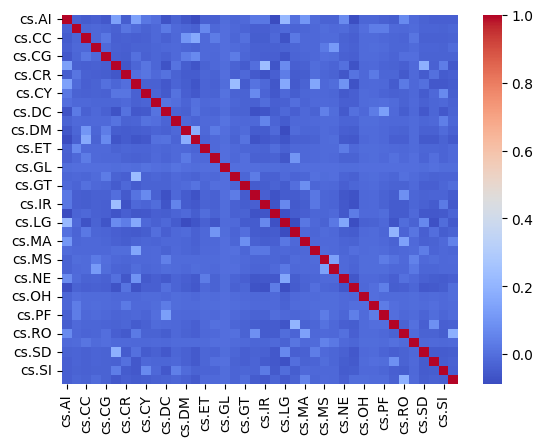

In [ ]:
df_features = df_filtered.drop('text', axis=1)
corr = df_features.corr()
sns.heatmap(corr, cmap='coolwarm')
# show the plot
plt.show()

In [37]:
# reshape the correlation matrix into a long format
corr_long = corr.stack().reset_index()
# rename the columns
corr_long.columns = ['feature1', 'feature2', 'correlation']

In [40]:
corr_long

,feature1,feature2,correlation
0,cs.CL,cs.CL,1.000000
242,cs.LG,cs.LG,1.000000
66,cs.CY,cs.CY,1.000000
88,cs.DB,cs.DB,1.000000
110,cs.ET,cs.ET,1.000000
...,...,...,...
231,cs.LG,cs.CL,-0.151729
50,cs.CV,cs.HC,-0.160509
170,cs.HC,cs.CV,-0.160509
42,cs.CV,cs.CL,-0.184530


In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel

In [ ]:

# Load the RoBERTa model
model = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize and encode the texts
embeddings = []
for text in tqdm(df_filtered["text"]):
    encoding = model.encode(text,truncation=True, padding="max_length", max_length=512)
    embeddings.append(encoding)

100%|██████████| 134376/134376 [13:51<00:00, 161.62it/s]


In [ ]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
from skmultilearn.model_selection import IterativeStratification

In [30]:
df_only_first_200 = df_filtered.iloc[:200]

In [31]:
df_only_first_200.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 207
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    200 non-null    object 
 1   cs.AI   200 non-null    float64
 2   cs.AR   200 non-null    float64
 3   cs.CC   200 non-null    float64
 4   cs.CE   200 non-null    float64
 5   cs.CG   200 non-null    float64
 6   cs.CL   200 non-null    float64
 7   cs.CR   200 non-null    float64
 8   cs.CV   200 non-null    float64
 9   cs.CY   200 non-null    float64
 10  cs.DB   200 non-null    float64
 11  cs.DC   200 non-null    float64
 12  cs.DL   200 non-null    float64
 13  cs.DM   200 non-null    float64
 14  cs.DS   200 non-null    float64
 15  cs.ET   200 non-null    float64
 16  cs.FL   200 non-null    float64
 17  cs.GL   200 non-null    float64
 18  cs.GR   200 non-null    float64
 19  cs.GT   200 non-null    float64
 20  cs.HC   200 non-null    float64
 21  cs.IR   200 non-null    float64
 22  cs

In [32]:
# Exclude the first column from consideration
columns_to_check = df_only_first_200.columns[1:]

# Calculate the sum of each column (excluding the first column)
column_sums = df_only_first_200[columns_to_check].sum()

# Identify the columns (excluding the first column) with a sum of 0
zero_sum_columns = column_sums[column_sums == 0].index

In [33]:
zero_sum_columns

Index(['cs.AR', 'cs.CC', 'cs.CE', 'cs.CG', 'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS',
       'cs.FL', 'cs.GL', 'cs.MS', 'cs.NA', 'cs.OH', 'cs.OS', 'cs.PF', 'cs.PL',
       'cs.SC', 'cs.SD'],
      dtype='object')

In [44]:
df_only_first_200 = df_only_first_200.drop('cs.AI', axis=1)

In [45]:
df_only_first_200

,text,cs.CL,cs.CR,cs.CV,cs.CY,cs.DB,cs.ET,cs.GR,cs.GT,cs.HC,...,cs.LG,cs.LO,cs.MA,cs.MM,cs.NE,cs.NI,cs.RO,cs.SE,cs.SI,cs.SY
0,TarViS: A Unified Approach for Target-based Vi...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Triple-stream Deep Metric Learning of Great Ap...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Feedback-Gated Rectified Linear Units. Feedbac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Multi-Agent Reinforcement Learning for Fast-Ti...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Multi-Vehicle Trajectory Prediction at Interse...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Backward Curriculum Reinforcement Learning. Th...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
204,WL-Align: Weisfeiler-Lehman Relabeling for Ali...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,Intrinsic Motivation in Dynamical Control Syst...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206,Current State of Community-Driven Radiological...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


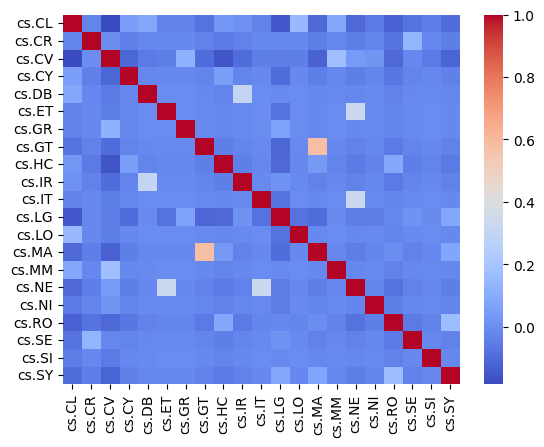

In [46]:
df_features = df_only_first_200.drop('text', axis=1)
corr = df_features.corr()
sns.heatmap(corr, cmap='coolwarm')
# show the plot
plt.show()

In [47]:
features = pd.unique(corr_long[['feature1', 'feature2']].values.ravel())
print(features)

['cs.CL' 'cs.LG' 'cs.CY' 'cs.DB' 'cs.ET' 'cs.GR' 'cs.GT' 'cs.HC' 'cs.IR'
 'cs.LO' 'cs.CR' 'cs.MA' 'cs.MM' 'cs.NE' 'cs.NI' 'cs.RO' 'cs.SE' 'cs.SI'
 'cs.CV' 'cs.IT' 'cs.SY']


In [48]:
# Create a dictionary of feature ids
feature_ids = {feature: i for i, feature in enumerate(features)}
print(feature_ids)

{'cs.CL': 0, 'cs.LG': 1, 'cs.CY': 2, 'cs.DB': 3, 'cs.ET': 4, 'cs.GR': 5, 'cs.GT': 6, 'cs.HC': 7, 'cs.IR': 8, 'cs.LO': 9, 'cs.CR': 10, 'cs.MA': 11, 'cs.MM': 12, 'cs.NE': 13, 'cs.NI': 14, 'cs.RO': 15, 'cs.SE': 16, 'cs.SI': 17, 'cs.CV': 18, 'cs.IT': 19, 'cs.SY': 20}


In [101]:
# sort the DataFrame by the correlation column in descending order
corr_long = corr_long.sort_values(by='correlation', ascending=False)
# filter the correlation matrix by the threshold
corr_filtered = corr[corr > 0.05]
# count the number of correlations above the threshold
corr_count = corr_filtered.count().sum()
# print the result
print(f"There are {corr_count} correlations above 0.3 threshold.")

There are 55 correlations above 0.3 threshold.


In [102]:
# Replace the feature names with their ids
corr_long['feature1'] = corr_long['feature1'].replace(feature_ids)
corr_long['feature2'] = corr_long['feature2'].replace(feature_ids)
print(corr_long)

     feature1  feature2  correlation
0           0         0     1.000000
286        11        11     1.000000
352        14        14     1.000000
330        13        13     1.000000
440        20        20     1.000000
..        ...       ...          ...
231         1         0    -0.151729
50         18         7    -0.160509
170         7        18    -0.160509
42         18         0    -0.184530
2           0        18    -0.184530

[441 rows x 3 columns]


In [105]:
# Filter the dataframe by correlation value
corr_long_filtered = corr_long[(corr_long['correlation'] > 0.05) & (corr_long['correlation'] < 1)]
print(corr_long_filtered)

     feature1  feature2  correlation
160         6        11     0.583185
280        11         6     0.583185
225        19        13     0.326564
325        13        19     0.326564
320        13         4     0.326564
120         4        13     0.326564
193         8         3     0.305776
93          3         8     0.305776
56         18        12     0.171787
296        12        18     0.171787
437        20        15     0.166359
377        15        20     0.166359
252         9         0     0.151302
12          0         9     0.151302
39         10        16     0.130744
379        16        10     0.130744
128         5        18     0.121166
48         18         5     0.121166
185         7        15     0.085383
365        15         7     0.085383
14          0        12     0.083712
294        12         0     0.083712
4           0         3     0.083712
84          3         0     0.083712
251         1        20     0.082061
431        20         1     0.082061
2

In [106]:
# Save the dataframe to a csv file
corr_long_filtered.to_csv('corr_long_filtered.csv', sep=',', encoding='utf-8', index=False)

In [55]:
def text_similarity(text1, text2):
    # Tokenize and lemmatize the texts
    tokens1 = word_tokenize(text1)
    tokens2 = word_tokenize(text2)
    lemmatizer = WordNetLemmatizer()
    tokens1 = [lemmatizer.lemmatize(token) for token in tokens1]
    tokens2 = [lemmatizer.lemmatize(token) for token in tokens2]

    # Remove stopwords
    stop_words = stopwords.words('english')
    tokens1 = [token for token in tokens1 if token not in stop_words]
    tokens2 = [token for token in tokens2 if token not in stop_words]

    # Join the tokens back into strings
    text1 = ' '.join(tokens1)
    text2 = ' '.join(tokens2)

    # Create the TF-IDF vectors
    vectorizer = TfidfVectorizer()
    vector1 = vectorizer.fit_transform([text1])
    vector2 = vectorizer.transform([text2])

    # Calculate the cosine similarity
    similarity = cosine_similarity(vector1, vector2)

    return similarity

In [ ]:
from scipy.spatial.distance import euclidean, cityblock


In [56]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [57]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [58]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [64]:
df_only_first_200.to_csv('df_only_first_200_with_id.csv', index=False)

In [85]:
# Transform the dataframe from wide to long format
df_long = df_only_first_200.melt(id_vars=['id', 'text'], var_name='variable', value_name='value')

# Filter the dataframe by the value column
df_long = df_long.query('value == 1')

# Drop the value column
df_long = df_long.drop('value', axis=1)

# Rename the columns
df_long = df_long.rename(columns={'variable': 'label_id', 'id': 'text_id'})

# Save the dataframe to a csv file


,text_id,text,label_id
5,6,"""No, to the Right"" -- Online Language Correcti...",cs.CL
6,7,SAIDS: A Novel Approach for Sentiment Analysis...,cs.CL
11,12,An Image captioning algorithm based on the Hyb...,cs.CL
17,18,Reasoning about Causality in Games. Causal rea...,cs.CL
22,23,All in Tokens: Unifying Output Space of Visual...,cs.CL
...,...,...,...
2773,174,Transformer in Transformer as Backbone for Dee...,cs.MA
2782,183,GPT Takes the Bar Exam. Nearly all jurisdictio...,cs.MA
2795,196,Backward Curriculum Reinforcement Learning. Th...,cs.MA
2833,34,MS-DINO: Efficient Distributed Training of Vis...,cs.MM


In [86]:
df_long.head()

,text_id,text,label_id
5,6,"""No, to the Right"" -- Online Language Correcti...",cs.CL
6,7,SAIDS: A Novel Approach for Sentiment Analysis...,cs.CL
11,12,An Image captioning algorithm based on the Hyb...,cs.CL
17,18,Reasoning about Causality in Games. Causal rea...,cs.CL
22,23,All in Tokens: Unifying Output Space of Visual...,cs.CL


In [87]:
df_long.to_csv('text_label.csv', index=False)


In [62]:
# Insert a new column named id at the first position
df_only_first_200.insert(0, 'id', range(1, 1 + len(df_only_first_200)))

In [78]:
df_only_first_200['id'].iloc[10]

11

In [71]:

tf_idf_similarity = []
for i in tqdm(range(len(df_only_first_200['text']))):
    for j in range(i+1, len(df_only_first_200['text'])):
      # print(text_similarity(df_only_first_200['text'].iloc[i], df_only_first_200['text'].iloc[j]))
      tf_idf_similarity.append((df_only_first_200['id'].iloc[i],
                                df_only_first_200['id'].iloc[j],
                                text_similarity(df_only_first_200['text'].iloc[i], df_only_first_200['text'].iloc[j])))


100%|██████████| 200/200 [03:50<00:00,  1.15s/it]


In [72]:
tf_idf_similarity = [(x, y, z[0][0]) for x, y, z in tf_idf_similarity]

In [73]:
from operator import itemgetter
sorted_tf_idf_similarity = sorted(tf_idf_similarity, key=itemgetter(2), reverse=True)


In [75]:
sorted_tf_idf_similarity[0:10]

[(74, 134, 0.7139372054277751),
 (9, 63, 0.7000020079687678),
 (9, 175, 0.6867010296219114),
 (1, 23, 0.6798086003384263),
 (1, 38, 0.671704214968214),
 (166, 175, 0.668426845747779),
 (9, 166, 0.6660519439295175),
 (152, 163, 0.6651031534464482),
 (128, 134, 0.6615701550312042),
 (3, 88, 0.6564879518897747)]

In [79]:
import csv

In [93]:
def check_third_value(t):
  return t[2] > 0.45

# Use the filter function to filter the list of tuples by the third value
filtered_tuples = filter(check_third_value, sorted_tf_idf_similarity)

# Convert the filtered iterator to a list
filtered_tuples = list(filtered_tuples)

# Print the filtered list
print(len(filtered_tuples))


833


In [94]:
# Write the results to a CSV file
with open("text_text_similarity_tf_idf.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["Text_1_id", "Text_2_id", "tf_idf_score_0.45"])
    writer.writerows(filtered_tuples)